In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import torch
from data_parser import data_loader_full
import io
from matplotlib import cm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from utils import params

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

file_path = 'Losses/loss_burnin_all.pkl'
with open(file_path, 'rb') as pickle_file:
    loss_burnin = CPU_Unpickler(pickle_file).load()

file_path = 'Losses/loss_main_all.pkl'
with open(file_path, 'rb') as pickle_file:
    loss_main = CPU_Unpickler(pickle_file).load()

file_path = 'Losses/loss_refine_all.pkl'
with open(file_path, 'rb') as pickle_file:
    loss_refine = CPU_Unpickler(pickle_file).load()

In [3]:
def moving_average(arr, window_size):
    window = np.ones(window_size) / window_size
    return np.convolve(arr, window, mode='valid')
window_size = 50

# Burin Losses Read

In [4]:
# burnin losses
occu_burnin = []
flow_burnin = []
speed_burnin = []
k_t_burnin = []
burnin_losses = []

In [5]:
num_epochs_burnin = params['burn_in_epoch']
for epoch_burnin in range(num_epochs_burnin):
    occu_burnin.append(loss_burnin[epoch_burnin]['occupancy'].item())
    flow_burnin.append(loss_burnin[epoch_burnin]['flow'].item())
    speed_burnin.append(loss_burnin[epoch_burnin]['speed'].item())
    k_t_burnin.append(loss_burnin[epoch_burnin]['k_t'].item())
    burnin_losses.append(params['occupancy_weight']*(loss_burnin[epoch_burnin]['occupancy'].item())\
                  +params['flow_weight']*(loss_burnin[epoch_burnin]['flow'].item())\
                  +params['speed_weight']*(loss_burnin[epoch_burnin]['speed'].item())\
                  +params['k_t_weight']*(loss_burnin[epoch_burnin]['k_t'].item()))

# Main Losses Read

In [6]:
# main losses
occu_main = []
flow_main = []
speed_main = []
k_t_main = []
main_losses = []

In [7]:
num_epochs_main = params['num_epochs']
for epoch_main in range(num_epochs_main):
    occu_main.append(loss_main[epoch_main]['occupancy'].item())
    flow_main.append(loss_main[epoch_main]['flow'].item())
    speed_main.append(loss_main[epoch_main]['speed'].item())
    k_t_main.append(loss_main[epoch_main]['k_t'].item())
    main_losses.append(params['occupancy_weight']*(loss_main[epoch_main]['occupancy'].item())\
                  +params['flow_weight']*(loss_main[epoch_main]['flow'].item())\
                  +params['speed_weight']*(loss_main[epoch_main]['speed'].item())\
                  +params['k_t_weight']*(loss_main[epoch_main]['k_t'].item())\
                  +params['sparsity_weight'] * loss_main[epoch_main]['sparsity'])

# Refinement Losses Read

In [8]:
# refine losses
occu_refine = []
flow_refine = []
speed_refine = []
k_t_refine = []
refine_losses = []

In [9]:
num_epochs_refine = params['refinement_epochs']
for epoch_refine in range(num_epochs_refine):
    occu_refine.append(loss_refine[epoch_refine]['occupancy'].item())
    flow_refine.append(loss_refine[epoch_refine]['flow'].item())
    speed_refine.append(loss_refine[epoch_refine]['speed'].item())
    k_t_refine.append(loss_refine[epoch_refine]['k_t'].item())
    refine_losses.append(params['occupancy_weight']*(loss_refine[epoch_refine]['occupancy'].item())\
                  +params['flow_weight']*(loss_refine[epoch_refine]['flow'].item())\
                  +params['speed_weight']*(loss_refine[epoch_refine]['speed'].item())\
                  +params['k_t_weight']*(loss_refine[epoch_refine]['k_t'].item()))

In [10]:
occu_all = occu_burnin + occu_main + occu_refine
flow_all = flow_burnin + flow_main + flow_refine
speed_all = speed_burnin + speed_main + speed_refine
k_t_all = k_t_burnin + k_t_main + k_t_refine
loss_all = burnin_losses + main_losses + refine_losses

In [11]:
len(occu_refine)

1500

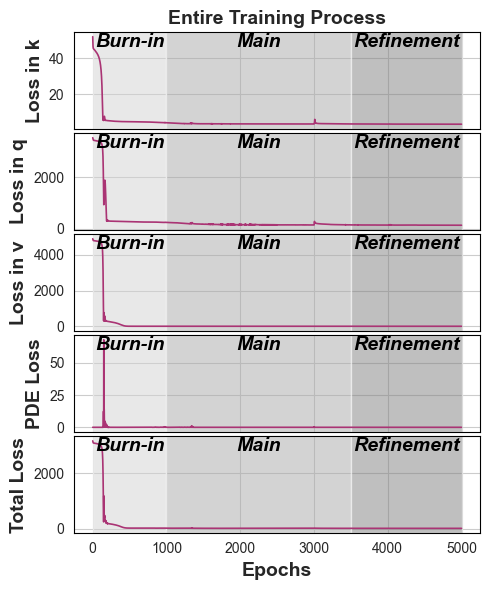

In [12]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(5,6), sharex=True)

axs[0].plot(occu_all, color = '#aa3474',label = "Training", linewidth = 1.2)
# axs[0].set_xlabel('Epochs', fontsize=14)
axs[0].set_ylabel('Loss in k', fontsize=14, weight = 'bold')
axs[0].set_title('Entire Training Process', fontsize=14, weight='bold')

burnin_regions = [0, 1000]
# Add different colored background regions
for i in range(0, len(burnin_regions)-1, 2):
    axs[0].axvspan(burnin_regions[i], burnin_regions[i+1], facecolor='lightgrey', alpha=0.5)
    text_x = (burnin_regions[i] + burnin_regions[i + 1]) / 2
    text_y = axs[0].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Burn-in'  # Customize the text as needed
    axs[0].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

main_regions = [1000, 3500]
# Add different colored background regions
for i in range(0, len(main_regions)-1, 2):
    axs[0].axvspan(main_regions[i], main_regions[i+1], facecolor='darkgrey', alpha=0.5)
    text_x = (main_regions[i] + main_regions[i + 1]) / 2
    text_y = axs[0].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Main'  # Customize the text as needed
    axs[0].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

refine_regions = [3500, 5000]
# Add different colored background regions
for i in range(0, len(refine_regions)-1, 2):
    axs[0].axvspan(refine_regions[i], refine_regions[i+1], facecolor='grey', alpha=0.5)
    text_x = (refine_regions[i] + refine_regions[i + 1]) / 2
    text_y = axs[0].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Refinement'  # Customize the text as needed
    axs[0].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')
# axs[0].grid(False)
axs[0].spines['top'].set_color('black')
axs[0].spines['bottom'].set_color('black')
axs[0].spines['left'].set_color('black')
axs[0].spines['right'].set_color('black')

axs[1].plot(flow_all, color = '#aa3474',label = "Training", linewidth = 1.2)
#axs[1].set_xlabel('Epochs', fontsize=14)
axs[1].set_ylabel('Loss in q', fontsize=14, weight = 'bold')
#axs.set_title('Lk', fontsize=14, weight='bold')

# burnin_regions = [0, 1000]
# Add different colored background regions
for i in range(0, len(burnin_regions)-1, 2):
    axs[1].axvspan(burnin_regions[i], burnin_regions[i+1], facecolor='lightgrey', alpha=0.5)
    text_x = (burnin_regions[i] + burnin_regions[i + 1]) / 2
    text_y = axs[1].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Burn-in'  # Customize the text as needed
    axs[1].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

# main_regions = [1000, 3000]
# Add different colored background regions
for i in range(0, len(main_regions)-1, 2):
    axs[1].axvspan(main_regions[i], main_regions[i+1], facecolor='darkgrey', alpha=0.5)
    text_x = (main_regions[i] + main_regions[i + 1]) / 2
    text_y = axs[1].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Main'  # Customize the text as needed
    axs[1].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

# refine_regions = [3000, 4000]
# Add different colored background regions
for i in range(0, len(refine_regions)-1, 2):
    axs[1].axvspan(refine_regions[i], refine_regions[i+1], facecolor='grey', alpha=0.5)
    text_x = (refine_regions[i] + refine_regions[i + 1]) / 2
    text_y = axs[1].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Refinement'  # Customize the text as needed
    axs[1].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')
# axs[1].grid(False)
axs[1].spines['top'].set_color('black')
axs[1].spines['bottom'].set_color('black')
axs[1].spines['left'].set_color('black')
axs[1].spines['right'].set_color('black')

axs[2].plot(speed_all, color = '#aa3474',label = "Training", linewidth = 1.2)
#axs[2].set_xlabel('Epochs', fontsize=14)
axs[2].set_ylabel('Loss in v', fontsize=14, weight = 'bold')
#axs.set_title('Lk', fontsize=14, weight='bold')

# burnin_regions = [0, 1000]
# Add different colored background regions
for i in range(0, len(burnin_regions)-1, 2):
    axs[2].axvspan(burnin_regions[i], burnin_regions[i+1], facecolor='lightgrey', alpha=0.5)
    text_x = (burnin_regions[i] + burnin_regions[i + 1]) / 2
    text_y = axs[2].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Burn-in'  # Customize the text as needed
    axs[2].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

# main_regions = [1000, 3000]
# Add different colored background regions
for i in range(0, len(main_regions)-1, 2):
    axs[2].axvspan(main_regions[i], main_regions[i+1], facecolor='darkgrey', alpha=0.5)
    text_x = (main_regions[i] + main_regions[i + 1]) / 2
    text_y = axs[2].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Main'  # Customize the text as needed
    axs[2].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

# refine_regions = [3000, 4000]
# Add different colored background regions
for i in range(0, len(refine_regions)-1, 2):
    axs[2].axvspan(refine_regions[i], refine_regions[i+1], facecolor='grey', alpha=0.5)
    text_x = (refine_regions[i] + refine_regions[i + 1]) / 2
    text_y = axs[2].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Refinement'  # Customize the text as needed
    axs[2].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')
# axs[2].grid(False)
axs[2].spines['top'].set_color('black')
axs[2].spines['bottom'].set_color('black')
axs[2].spines['left'].set_color('black')
axs[2].spines['right'].set_color('black')

axs[3].plot(k_t_all, color = '#aa3474',label = "Training", linewidth = 1.2)
#axs[3].set_xlabel('Epochs', fontsize=14)
axs[3].set_ylabel('PDE Loss', fontsize=14, weight = 'bold')
#axs.set_title('Lk', fontsize=14, weight='bold')

# burnin_regions = [0, 1000]
# Add different colored background regions
for i in range(0, len(burnin_regions)-1, 2):
    axs[3].axvspan(burnin_regions[i], burnin_regions[i+1], facecolor='lightgrey', alpha=0.5)
    text_x = (burnin_regions[i] + burnin_regions[i + 1]) / 2
    text_y = axs[3].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Burn-in'  # Customize the text as needed
    axs[3].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

# main_regions = [1000, 3000]
# Add different colored background regions
for i in range(0, len(main_regions)-1, 2):
    axs[3].axvspan(main_regions[i], main_regions[i+1], facecolor='darkgrey', alpha=0.5)
    text_x = (main_regions[i] + main_regions[i + 1]) / 2
    text_y = axs[3].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Main'  # Customize the text as needed
    axs[3].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

# refine_regions = [3000, 4000]
# Add different colored background regions
for i in range(0, len(refine_regions)-1, 2):
    axs[3].axvspan(refine_regions[i], refine_regions[i+1], facecolor='grey', alpha=0.5)
    text_x = (refine_regions[i] + refine_regions[i + 1]) / 2
    text_y = axs[3].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Refinement'  # Customize the text as needed
    axs[3].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')
# axs[3].grid(False)
axs[3].spines['top'].set_color('black')
axs[3].spines['bottom'].set_color('black')
axs[3].spines['left'].set_color('black')
axs[3].spines['right'].set_color('black')

axs[4].plot(loss_all, color = '#aa3474',label = "Training", linewidth = 1.2)
axs[4].set_xlabel('Epochs', fontsize=14, weight = 'bold')
axs[4].set_ylabel('Total Loss', fontsize=14, weight = 'bold')
#axs.set_title('Lk', fontsize=14, weight='bold')

# burnin_regions = [0, 1000]
# Add different colored background regions
for i in range(0, len(burnin_regions)-1, 2):
    axs[4].axvspan(burnin_regions[i], burnin_regions[i+1], facecolor='lightgrey', alpha=0.5)
    text_x = (burnin_regions[i] + burnin_regions[i + 1]) / 2
    text_y = axs[4].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Burn-in'  # Customize the text as needed
    axs[4].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

# main_regions = [1000, 3000]
# Add different colored background regions
for i in range(0, len(main_regions)-1, 2):
    axs[4].axvspan(main_regions[i], main_regions[i+1], facecolor='darkgrey', alpha=0.5)
    text_x = (main_regions[i] + main_regions[i + 1]) / 2
    text_y = axs[4].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Main'  # Customize the text as needed
    axs[4].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

# refine_regions = [3000, 4000]
# Add different colored background regions
for i in range(0, len(refine_regions)-1, 2):
    axs[4].axvspan(refine_regions[i], refine_regions[i+1], facecolor='grey', alpha=0.5)
    text_x = (refine_regions[i] + refine_regions[i + 1]) / 2
    text_y = axs[4].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Refinement'  # Customize the text as needed
    axs[4].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')
# axs[4].grid(False)
axs[4].spines['top'].set_color('black')
axs[4].spines['bottom'].set_color('black')
axs[4].spines['left'].set_color('black')
axs[4].spines['right'].set_color('black')
plt.tight_layout()
#plt.subplots_adjust(hspace=0.1, wspace=0.3)

plt.subplots_adjust(hspace=0.05)
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
# fig.savefig("Figures/Losses/All_loss_plots.png", dpi = 300)

# Main Refinement Step Detailed Plots


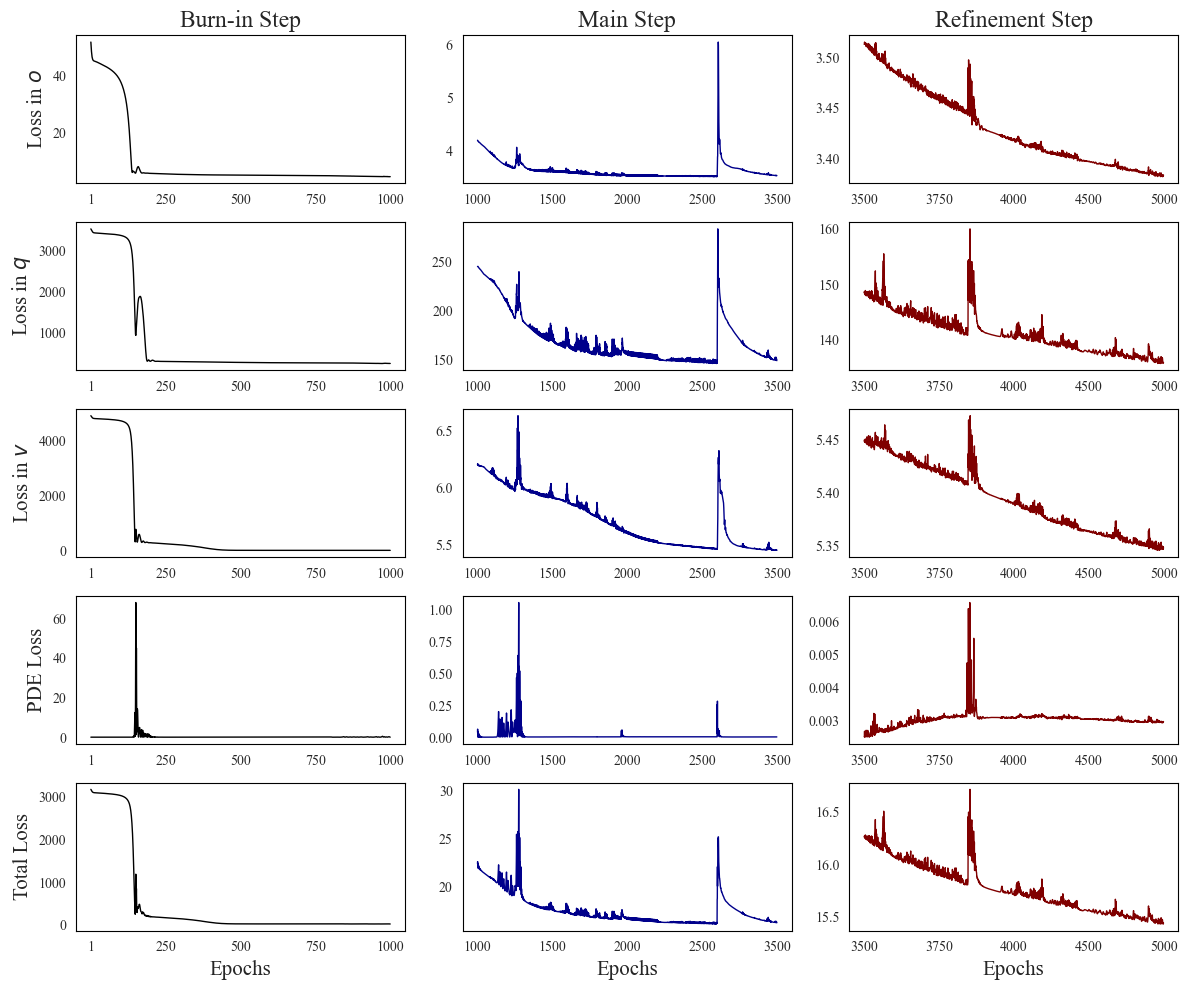

In [16]:
import numpy as np

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12,10), sharex=False)

# Define a function to set spine color
def set_spine_color(ax):
    for spine in ax.spines.values():
        spine.set_color('black')

# Define a function to plot with common properties
def plot_data(ax, data, title=None, xlabel=None, ylabel=None, x_ticks=None, x_labels=None, color='#1f77b4', linewidth=1):
    ax.plot(data, color=color, linewidth=linewidth)
    if title:
        ax.set_title(title, fontsize=17)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=15)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=15)
    ax.grid(False)
    set_spine_color(ax)
    
    # Set x-ticks and labels if provided
    if x_ticks is not None and x_labels is not None:
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
    
    #  # Set five y-tick levels
    # y_min, y_max = ax.get_ylim()
    # if y_min < 0:
    #     y_min = 0
    # y_ticks = np.round(np.linspace(y_min, y_max, 5), 2) # Get the current y-limits
    # ax.set_yticks(y_ticks)  # Set 5 evenly spaced y-ticks

# Define colors for each training step
burnin_color = 'black'  # Blue
main_color = 'darkblue'    # Green
refine_color = 'maroon'  # Orange

# Define x-tick intervals and labels for each phase
burnin_ticks = [1, 250, 500, 750, 1000]
main_ticks = [1, 625, 1250, 1875, 2500]
refine_ticks = [1, 375, 750, 1125, 1500]

burnin_labels = ['1', '250', '500', '750', '1000']
main_labels = ['1000', '1500', '2000', '2500', '3500']
refine_labels = ['3500', '3750', '4000', '4500', '5000']

# Plot all subplots with different colors and x-axis ranges for each training step
plot_data(axs[0, 0], occu_burnin, title='Burn-in Step', ylabel='Loss in $o$', color=burnin_color, x_ticks=burnin_ticks, x_labels=burnin_labels)
plot_data(axs[0, 1], occu_main, title='Main Step', color=main_color, x_ticks=main_ticks, x_labels=main_labels)
plot_data(axs[0, 2], occu_refine, title='Refinement Step', color=refine_color, x_ticks=refine_ticks, x_labels=refine_labels)

plot_data(axs[1, 0], flow_burnin, ylabel='Loss in $q$', color=burnin_color, x_ticks=burnin_ticks, x_labels=burnin_labels)
plot_data(axs[1, 1], flow_main, color=main_color, x_ticks=main_ticks, x_labels=main_labels)
plot_data(axs[1, 2], flow_refine, color=refine_color, x_ticks=refine_ticks, x_labels=refine_labels)

plot_data(axs[2, 0], speed_burnin, ylabel='Loss in $v$', color=burnin_color, x_ticks=burnin_ticks, x_labels=burnin_labels)
plot_data(axs[2, 1], speed_main, color=main_color, x_ticks=main_ticks, x_labels=main_labels)
plot_data(axs[2, 2], speed_refine, color=refine_color, x_ticks=refine_ticks, x_labels=refine_labels)

plot_data(axs[3, 0], k_t_burnin, ylabel='PDE Loss', color=burnin_color, x_ticks=burnin_ticks, x_labels=burnin_labels)
plot_data(axs[3, 1], k_t_main, color=main_color, x_ticks=main_ticks, x_labels=main_labels)
plot_data(axs[3, 2], k_t_refine, color=refine_color, x_ticks=refine_ticks, x_labels=refine_labels)

plot_data(axs[4, 0], burnin_losses, xlabel='Epochs', ylabel='Total Loss', color=burnin_color, x_ticks=burnin_ticks, x_labels=burnin_labels)
plot_data(axs[4, 1], main_losses, xlabel='Epochs', color=main_color, x_ticks=main_ticks, x_labels=main_labels)
plot_data(axs[4, 2], refine_losses, xlabel='Epochs', color=refine_color, x_ticks=refine_ticks, x_labels=refine_labels)

plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Losses/All_loss_plots.png", dpi = 300)